# Predicting Formula 1 Safety Cars: A Temporal Machine Learning Tutorial

## 🏁 Introduction

Welcome to this hands-on tutorial on predicting safety car deployments in Formula 1 using temporal machine learning! In this notebook, we'll build a system that slides through race data minute-by-minute, asking: **"Will a safety car be deployed in the next 2 minutes?"**

### What You'll Learn:
1. How to work with F1 telemetry data using FastF1
2. The concept of temporal sliding windows for time-series prediction
3. Feature engineering from racing telemetry
4. Training a model for imbalanced classification
5. Evaluating predictions with proper temporal validation

### Prerequisites:
- Basic Python knowledge
- Understanding of pandas DataFrames
- Familiarity with basic ML concepts (classification, train/test split)

Let's start our journey!

In [17]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import fastf1 as f1
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Set up nice plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 📊 Chapter 1: Understanding the Data Source

Before we dive into predictions, let's understand what data we're working with. FastF1 provides access to official F1 timing data.

In [18]:
# Load a session with known safety car deployments
# We'll use Saudi Arabia 2024 as our example
session = f1.get_session(2024, 'Saudi Arabian Grand Prix', 'R')
session.load()

print(f"🏎️ Loaded: {session.event['EventName']} - {session.name}")
print(f"📅 Date: {session.date}")

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


🏎️ Loaded: Saudi Arabian Grand Prix - Race
📅 Date: 2024-03-09 17:00:00


### 1.1 Exploring Lap Data

The core of our analysis is lap-by-lap telemetry for each driver:

In [19]:
# Get the laps dataframe
laps_df = session.laps

print(f"Total laps in dataset: {len(laps_df)}")
print(f"Drivers in race: {laps_df['Driver'].nunique()}")
print(f"\nColumns available:")
print(laps_df.columns.tolist())

# Let's look at a sample of the data
print("\nSample lap data:")
laps_df.head()

Total laps in dataset: 901
Drivers in race: 20

Columns available:
['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']

Sample lap data:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:19.630000,VER,1,0 days 00:01:35.505000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.707000,...,True,Red Bull Racing,0 days 00:59:43.836000,2024-03-09 17:03:59.056,1,1.0,False,,False,False
1,0 days 01:02:53.835000,VER,1,0 days 00:01:34.205000,2.0,1.0,NaT,NaT,0 days 00:00:34.720000,0 days 00:00:29.628000,...,True,Red Bull Racing,0 days 01:01:19.630000,2024-03-09 17:05:34.850,1,1.0,False,,False,True
2,0 days 01:04:27.878000,VER,1,0 days 00:01:34.043000,3.0,1.0,NaT,NaT,0 days 00:00:34.530000,0 days 00:00:29.621000,...,True,Red Bull Racing,0 days 01:02:53.835000,2024-03-09 17:07:09.055,1,1.0,False,,False,True
3,0 days 01:06:01.632000,VER,1,0 days 00:01:33.754000,4.0,1.0,NaT,NaT,0 days 00:00:34.416000,0 days 00:00:29.541000,...,True,Red Bull Racing,0 days 01:04:27.878000,2024-03-09 17:08:43.098,1,1.0,False,,False,True
4,0 days 01:07:35.587000,VER,1,0 days 00:01:33.955000,5.0,1.0,NaT,NaT,0 days 00:00:34.457000,0 days 00:00:29.590000,...,True,Red Bull Racing,0 days 01:06:01.632000,2024-03-09 17:10:16.852,1,1.0,False,,False,True


### 1.2 Understanding Timing in F1 Data

**Critical Concept**: F1 uses "SessionTime" - time elapsed since the session started. This is different from wall clock time!

In [20]:
# Examine different time columns
sample_lap = laps_df.iloc[100]

print("🕐 Time columns explained:")
print(f"LapStartTime: {sample_lap['LapStartTime']} (When the lap began)")
print(f"Time: {sample_lap['Time']} (When the lap ended)")
print(f"LapTime: {sample_lap['LapTime']} (Duration of the lap)")

# These are Timedelta objects - let's convert to minutes for clarity
if pd.notna(sample_lap['LapStartTime']):
    start_minutes = sample_lap['LapStartTime'].total_seconds() / 60
    print(f"\nLap started at: {start_minutes:.1f} minutes into the session")

🕐 Time columns explained:
LapStartTime: 0 days 02:19:03.186000 (When the lap began)
Time: 0 days 02:20:36.017000 (When the lap ended)
LapTime: 0 days 00:01:32.831000 (Duration of the lap)

Lap started at: 139.1 minutes into the session


### 1.3 Finding Safety Car Events

Safety cars are tracked in the `track_status` data:

In [21]:
session.laps.iloc[0].to_frame()

,0
Time,0 days 01:01:19.630000
Driver,VER
DriverNumber,1
LapTime,0 days 00:01:35.505000
LapNumber,1.0
Stint,1.0
PitOutTime,NaT
PitInTime,NaT
Sector1Time,NaT
Sector2Time,0 days 00:00:29.707000


In [22]:
session.laps.iloc[0].get_car_data()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime
0,2024-03-09 17:03:59.140,10085.0,0.0,1,15.0,True,1,car,0 days 00:00:00.084000,0 days 00:59:43.920000
1,2024-03-09 17:03:59.500,9420.0,0.0,1,15.0,False,1,car,0 days 00:00:00.444000,0 days 00:59:44.280000
2,2024-03-09 17:03:59.860,6900.0,11.0,1,15.0,False,1,car,0 days 00:00:00.804000,0 days 00:59:44.640000
3,2024-03-09 17:04:00.099,5220.0,22.0,1,15.0,False,1,car,0 days 00:00:01.043000,0 days 00:59:44.879000
4,2024-03-09 17:04:00.459,3743.0,32.0,1,16.0,False,1,car,0 days 00:00:01.403000,0 days 00:59:45.239000
...,...,...,...,...,...,...,...,...,...,...
369,2024-03-09 17:05:33.260,11170.0,282.0,7,100.0,False,1,car,0 days 00:01:34.204000,0 days 01:01:18.040000
370,2024-03-09 17:05:33.700,11326.0,285.0,7,100.0,False,1,car,0 days 00:01:34.644000,0 days 01:01:18.480000
371,2024-03-09 17:05:34.060,11373.0,288.0,7,100.0,False,1,car,0 days 00:01:35.004000,0 days 01:01:18.840000
372,2024-03-09 17:05:34.379,11419.0,291.0,7,100.0,False,1,car,0 days 00:01:35.323000,0 days 01:01:19.159000


In [23]:
session.laps.iloc[0].get_weather_data()

Time             0 days 01:00:08.558000
AirTemp                            25.4
Humidity                           62.0
Pressure                         1012.5
Rainfall                          False
TrackTemp                          31.5
WindDirection                       358
WindSpeed                           1.3
Name: 60, dtype: object

In [24]:
session.laps.iloc[0].get_pos_data().head(20)

,Date,Status,X,Y,Z,Source,Time,SessionTime
0,2024-03-09 17:03:59.251,OnTrack,-2081.0,2372.0,117.0,pos,0 days 00:00:00.195000,0 days 00:59:44.031000
1,2024-03-09 17:03:59.491,OnTrack,-2081.0,2372.0,117.0,pos,0 days 00:00:00.435000,0 days 00:59:44.271000
2,2024-03-09 17:03:59.671,OnTrack,-2083.0,2376.0,117.0,pos,0 days 00:00:00.615000,0 days 00:59:44.451000
3,2024-03-09 17:03:59.951,OnTrack,-2085.0,2381.0,117.0,pos,0 days 00:00:00.895000,0 days 00:59:44.731000
4,2024-03-09 17:04:00.191,OnTrack,-2089.0,2394.0,117.0,pos,0 days 00:00:01.135000,0 days 00:59:44.971000
5,2024-03-09 17:04:00.491,OnTrack,-2098.0,2418.0,117.0,pos,0 days 00:00:01.435000,0 days 00:59:45.271000
6,2024-03-09 17:04:00.711,OnTrack,-2108.0,2446.0,117.0,pos,0 days 00:00:01.655000,0 days 00:59:45.491000
7,2024-03-09 17:04:01.091,OnTrack,-2124.0,2489.0,117.0,pos,0 days 00:00:02.035000,0 days 00:59:45.871000
8,2024-03-09 17:04:01.371,OnTrack,-2141.0,2535.0,117.0,pos,0 days 00:00:02.315000,0 days 00:59:46.151000
9,2024-03-09 17:04:01.491,OnTrack,-2149.0,2558.0,117.0,pos,0 days 00:00:02.435000,0 days 00:59:46.271000


In [25]:
session.track_status

,Time,Status,Message
0,0 days 00:00:00,2,Yellow
1,0 days 00:08:45.692000,1,AllClear
2,0 days 01:09:15.917000,2,Yellow
3,0 days 01:09:49.924000,4,SCDeployed
4,0 days 01:16:35.527000,1,AllClear


In [41]:
# Get track status data
track_status_df = session.track_status

# Status codes in F1:
# '1' = Track Clear (Green flag)
# '2' = Yellow flag
# '4' = Safety Car
# '5' = Red flag

# Find all safety car deployments
safety_cars = track_status_df[track_status_df['Status'] == '4']

print(f"Found {len(safety_cars)} safety car deployments:")
for _, sc in safety_cars.iterrows():
    # Convert SessionTime to minutes for readability
    time_minutes = sc['Time'].total_seconds() / 60
    print(f"   Safety car at: {time_minutes:.1f} minutes into race")

Found 1 safety car deployments:
   Safety car at: 69.8 minutes into race


## 📈 Chapter 2: The Temporal Sliding Window Approach

Now comes the key insight: We want to predict safety cars BEFORE they happen. We'll use a sliding window approach.

### 2.1 Conceptual Overview

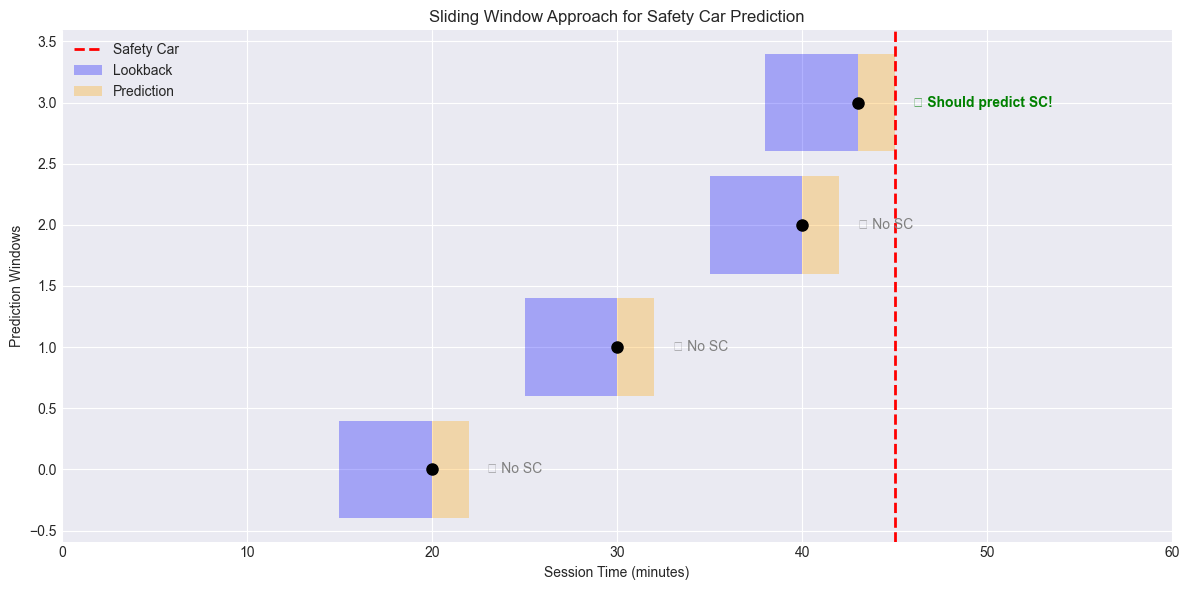

In [27]:
# Let's visualize the sliding window concept
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create a timeline
session_duration = 120  # minutes (example)
timeline = np.arange(0, session_duration, 1)

# Example safety car at 45 minutes
sc_time = 45

# Show multiple prediction windows
window_times = [20, 30, 40, 43]  # When we make predictions
lookback = 5  # How far back we look
horizon = 2   # How far ahead we predict

for i, pred_time in enumerate(window_times):
    # Draw lookback window
    ax.barh(i, lookback, left=pred_time-lookback, height=0.8, 
            alpha=0.3, color='blue', label='Lookback' if i==0 else '')
    
    # Draw prediction window
    ax.barh(i, horizon, left=pred_time, height=0.8, 
            alpha=0.3, color='orange', label='Prediction' if i==0 else '')
    
    # Mark prediction time
    ax.plot(pred_time, i, 'ko', markersize=8)
    
    # Check if this window should predict the SC
    if pred_time <= sc_time <= pred_time + horizon:
        ax.text(pred_time + horizon + 1, i, '✓ Should predict SC!', 
                va='center', color='green', fontweight='bold')
    else:
        ax.text(pred_time + horizon + 1, i, '✗ No SC', 
                va='center', color='gray')

# Mark the safety car
ax.axvline(sc_time, color='red', linestyle='--', linewidth=2, label='Safety Car')

ax.set_xlabel('Session Time (minutes)')
ax.set_ylabel('Prediction Windows')
ax.set_title('Sliding Window Approach for Safety Car Prediction')
ax.legend()
ax.set_xlim(0, 60)
plt.tight_layout()
plt.show()

### 2.2 Creating Temporal Windows for One Driver

Let's implement this for a single driver first:

In [28]:
# Pick a driver to analyze
driver = 'VER'  # Max Verstappen
driver_laps = laps_df[laps_df['Driver'] == driver].copy()

print(f"🏎️ Analyzing {driver}")
print(f"Total laps: {len(driver_laps)}")

# Create sliding windows
def create_driver_windows(driver_laps, safety_car_times, 
                         time_step=60, lookback=300, horizon=120):
    """
    Create temporal windows for prediction.
    
    Parameters:
    - time_step: How often to predict (seconds)
    - lookback: Historical data window (seconds)
    - horizon: Prediction window (seconds)
    """
    windows = []
    
    # Get session bounds
    session_start = driver_laps['LapStartTime'].min()
    session_end = driver_laps['Time'].max()
    
    # Start when we have enough history
    current_time = session_start + pd.Timedelta(seconds=lookback)
    
    while current_time + pd.Timedelta(seconds=horizon) <= session_end:
        # Define windows
        window_start = current_time - pd.Timedelta(seconds=lookback)
        window_end = current_time
        pred_start = current_time
        pred_end = current_time + pd.Timedelta(seconds=horizon)
        
        # Get laps in lookback window
        window_laps = driver_laps[
            (driver_laps['LapStartTime'] >= window_start) & 
            (driver_laps['LapStartTime'] <= window_end)
        ]
        
        # Check if SC will occur in prediction window
        sc_in_window = any(
            pred_start <= sc_time <= pred_end 
            for sc_time in safety_car_times
        )
        
        if len(window_laps) > 0:  # Only if we have data
            windows.append({
                'window_start': window_start,
                'window_end': window_end,
                'prediction_time': current_time,
                'prediction_end': pred_end,
                'laps_data': window_laps,
                'num_laps': len(window_laps),
                'should_predict_sc': sc_in_window
            })
        
        # Slide forward
        current_time += pd.Timedelta(seconds=time_step)
    
    return windows

# Extract safety car times
sc_times = [sc['Time'] for _, sc in safety_cars.iterrows()]

# Create windows for our driver
driver_windows = create_driver_windows(driver_laps, sc_times)

print(f"\n📊 Created {len(driver_windows)} prediction windows")
print(f"Windows with SC: {sum(w['should_predict_sc'] for w in driver_windows)}")
print(f"Windows without SC: {sum(not w['should_predict_sc'] for w in driver_windows)}")

🏎️ Analyzing VER
Total laps: 50

📊 Created 74 prediction windows
Windows with SC: 2
Windows without SC: 72


## 🔧 Chapter 3: Feature Engineering

Now we'll extract meaningful features from each temporal window. The key question: **What observable patterns might precede a safety car?**

### 3.1 Basic Lap Time Features

In [29]:
def extract_laptime_features(window_laps):
    """Extract features related to lap times."""
    features = {}
    
    if 'LapTime' not in window_laps.columns or len(window_laps) == 0:
        return features
    
    # Convert lap times to seconds
    lap_times = window_laps['LapTime'].dropna()
    if len(lap_times) == 0:
        return features
    
    # Handle timedelta conversion
    if pd.api.types.is_timedelta64_dtype(lap_times):
        lap_seconds = lap_times.dt.total_seconds()
    else:
        lap_seconds = pd.to_numeric(lap_times, errors='coerce')
    
    lap_seconds = lap_seconds.dropna()
    
    if len(lap_seconds) > 0:
        features['laptime_mean'] = lap_seconds.mean()
        features['laptime_std'] = lap_seconds.std() if len(lap_seconds) > 1 else 0
        features['laptime_min'] = lap_seconds.min()
        features['laptime_max'] = lap_seconds.max()
        
        # Consistency metric - how variable are the lap times?
        if lap_seconds.mean() > 0:
            features['laptime_consistency'] = lap_seconds.std() / lap_seconds.mean()
        else:
            features['laptime_consistency'] = 0
            
    return features

# Test on a window
test_window = driver_windows[50]
laptime_features = extract_laptime_features(test_window['laps_data'])

print("🏁 Lap time features extracted:")
for feature, value in laptime_features.items():
    print(f"   {feature}: {value:.2f}")

🏁 Lap time features extracted:
   laptime_mean: 92.47
   laptime_std: 0.14
   laptime_min: 92.31
   laptime_max: 92.56
   laptime_consistency: 0.00


### 3.2 Trend Detection Features

Are lap times getting worse? This might indicate a problem:

In [30]:
def extract_trend_features(window_laps):
    """Extract features about trends and changes."""
    features = {}
    
    if len(window_laps) < 2:
        return features
    
    # Sort by time
    laps_sorted = window_laps.sort_values('LapStartTime')
    
    # Lap time trend
    if 'LapTime' in laps_sorted.columns:
        lap_times = laps_sorted['LapTime'].dropna()
        if len(lap_times) >= 2:
            # Convert to seconds
            if pd.api.types.is_timedelta64_dtype(lap_times):
                lap_seconds = lap_times.dt.total_seconds()
            else:
                lap_seconds = pd.to_numeric(lap_times, errors='coerce')
            
            lap_seconds = lap_seconds.dropna().values
            
            if len(lap_seconds) >= 2:
                # Linear trend - are times improving (negative) or worsening (positive)?
                x = np.arange(len(lap_seconds))
                if np.var(x) > 0:
                    correlation = np.corrcoef(x, lap_seconds)[0, 1]
                    features['laptime_trend'] = correlation if not np.isnan(correlation) else 0
                
                # Recent vs early performance
                if len(lap_seconds) >= 4:
                    mid = len(lap_seconds) // 2
                    early_mean = lap_seconds[:mid].mean()
                    recent_mean = lap_seconds[mid:].mean()
                    features['recent_vs_early'] = recent_mean - early_mean
                
                # Most recent change
                features['last_lap_delta'] = lap_seconds[-1] - lap_seconds[-2]
    
    return features

# Test trend features
trend_features = extract_trend_features(test_window['laps_data'])

print("📈 Trend features extracted:")
for feature, value in trend_features.items():
    if abs(value) < 0.01:
        print(f"   {feature}: {value:.4f}")
    else:
        print(f"   {feature}: {value:.2f}")

📈 Trend features extracted:
   laptime_trend: 0.05
   last_lap_delta: 0.25


### 3.3 Position and Competition Features

In [31]:
def extract_position_features(window_laps):
    """Extract features about race position and changes."""
    features = {}
    
    if 'Position' not in window_laps.columns or len(window_laps) == 0:
        return features
    
    positions = window_laps['Position'].dropna()
    if len(positions) == 0:
        return features
    
    features['current_position'] = positions.iloc[-1]
    features['avg_position'] = positions.mean()
    
    if len(positions) > 1:
        features['position_changes'] = abs(positions.diff()).sum()
        features['position_gained'] = positions.iloc[0] - positions.iloc[-1]
        features['position_volatility'] = positions.std()
    
    return features

# Test position features
position_features = extract_position_features(test_window['laps_data'])

print("🏆 Position features extracted:")
for feature, value in position_features.items():
    print(f"   {feature}: {value:.2f}")

🏆 Position features extracted:
   current_position: 1.00
   avg_position: 1.00
   position_changes: 0.00
   position_gained: 0.00
   position_volatility: 0.00


### 3.4 Tire and Strategy Features

In [32]:
def extract_tire_features(window_laps):
    """Extract features about tire wear and strategy."""
    features = {}
    
    # Tire age
    if 'TyreLife' in window_laps.columns:
        tyre_life = window_laps['TyreLife'].dropna()
        if len(tyre_life) > 0:
            features['current_tyre_age'] = tyre_life.iloc[-1]
            features['avg_tyre_age'] = tyre_life.mean()
            features['max_tyre_age'] = tyre_life.max()
    
    # Stint information
    if 'Stint' in window_laps.columns:
        stints = window_laps['Stint'].dropna()
        if len(stints) > 0:
            features['current_stint'] = stints.iloc[-1]
            features['stint_changes'] = stints.nunique() - 1
    
    return features

# Test tire features
tire_features = extract_tire_features(test_window['laps_data'])

print("🛞 Tire/Strategy features extracted:")
for feature, value in tire_features.items():
    print(f"   {feature}: {value:.0f}")

🛞 Tire/Strategy features extracted:
   current_tyre_age: 27
   avg_tyre_age: 26
   max_tyre_age: 27
   current_stint: 2
   stint_changes: 0


### 3.5 Combining All Features

In [33]:
def extract_all_features(window):
    """Extract all features from a temporal window."""
    laps_data = window['laps_data']
    
    # Start with metadata
    features = {
        'prediction_time': window['prediction_time'],
        'num_laps_in_window': window['num_laps'],
        'target_sc': int(window['should_predict_sc'])  # Our target variable!
    }
    
    # Add all feature groups
    features.update(extract_laptime_features(laps_data))
    features.update(extract_trend_features(laps_data))
    features.update(extract_position_features(laps_data))
    features.update(extract_tire_features(laps_data))
    
    return features

# Process all windows for our driver
driver_features = []
for window in driver_windows:
    features = extract_all_features(window)
    driver_features.append(features)

# Convert to DataFrame
driver_features_df = pd.DataFrame(driver_features)

print(f"📊 Feature matrix shape: {driver_features_df.shape}")
print(f"\nFeatures extracted:")
for col in driver_features_df.columns:
    if col not in ['prediction_time', 'target_sc']:
        print(f"   - {col}")

📊 Feature matrix shape: (74, 21)

Features extracted:
   - num_laps_in_window
   - laptime_mean
   - laptime_std
   - laptime_min
   - laptime_max
   - laptime_consistency
   - laptime_trend
   - recent_vs_early
   - last_lap_delta
   - current_position
   - avg_position
   - position_changes
   - position_gained
   - position_volatility
   - current_tyre_age
   - avg_tyre_age
   - max_tyre_age
   - current_stint
   - stint_changes


In [34]:
display(driver_features_df)

,prediction_time,num_laps_in_window,target_sc,laptime_mean,laptime_std,laptime_min,laptime_max,laptime_consistency,laptime_trend,recent_vs_early,...,current_position,avg_position,position_changes,position_gained,position_volatility,current_tyre_age,avg_tyre_age,max_tyre_age,current_stint,stint_changes
0,0 days 01:04:43.836000,4,0,94.376750,0.774952,93.754,95.505,0.008211,-0.902086,-0.9565,...,1.0,1.0,0.0,0.0,0.0,4.0,2.5,4.0,1.0,0
1,0 days 01:05:43.836000,3,0,94.000667,0.228461,93.754,94.205,0.002430,-0.987040,NaN,...,1.0,1.0,0.0,0.0,0.0,4.0,3.0,4.0,1.0,0
2,0 days 01:06:43.836000,3,0,93.917333,0.148136,93.754,94.043,0.001577,-0.297024,NaN,...,1.0,1.0,0.0,0.0,0.0,5.0,4.0,5.0,1.0,0
3,0 days 01:07:43.836000,4,0,93.857000,0.170851,93.676,94.043,0.001820,-0.680064,-0.0830,...,1.0,1.0,0.0,0.0,0.0,6.0,4.5,6.0,1.0,0
4,0 days 01:08:43.836000,3,1,93.795000,0.143948,93.676,93.955,0.001535,-0.270931,NaN,...,1.0,1.0,0.0,0.0,0.0,6.0,5.0,6.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0 days 02:13:43.836000,3,0,92.758667,0.336024,92.377,93.010,0.003623,0.761850,NaN,...,1.0,1.0,0.0,0.0,0.0,39.0,38.0,39.0,2.0,0
70,0 days 02:14:43.836000,3,0,92.894333,0.113094,92.784,93.010,0.001217,-0.999166,NaN,...,1.0,1.0,0.0,0.0,0.0,40.0,39.0,40.0,2.0,0
71,0 days 02:15:43.836000,3,0,92.894333,0.113094,92.784,93.010,0.001217,-0.999166,NaN,...,1.0,1.0,0.0,0.0,0.0,40.0,39.0,40.0,2.0,0
72,0 days 02:16:43.836000,3,0,92.745333,0.166404,92.563,92.889,0.001794,-0.979543,NaN,...,1.0,1.0,0.0,0.0,0.0,41.0,40.0,41.0,2.0,0


## 🎯 Chapter 4: Understanding the Target Variable

Let's examine our prediction target more closely:

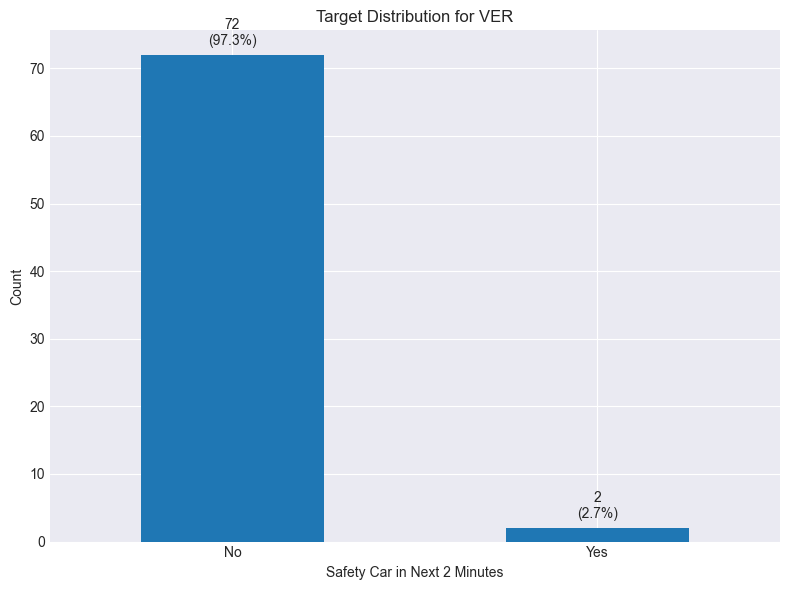

⚠️ Class imbalance: 2.7% positive samples
This is typical - safety cars are rare events!


In [35]:
# Analyze target distribution
target_counts = driver_features_df['target_sc'].value_counts()

plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar')
plt.title(f'Target Distribution for {driver}')
plt.xlabel('Safety Car in Next 2 Minutes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

# Add percentage labels
total = len(driver_features_df)
for i, count in enumerate(target_counts):
    plt.text(i, count + 1, f'{count}\n({count/total*100:.1f}%)', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"⚠️ Class imbalance: {target_counts[1]/total*100:.1f}% positive samples")
print("This is typical - safety cars are rare events!")

## 🤖 Chapter 5: Building the Prediction Model

Now let's train a model! We'll start simple with logistic regression.

### 5.1 Preparing Data for All Drivers

In [36]:
# Process all drivers
all_features = []

for driver in laps_df['Driver'].unique():
    driver_laps = laps_df[laps_df['Driver'] == driver]
    
    # Create windows
    windows = create_driver_windows(driver_laps, sc_times)
    
    # Extract features
    for window in windows:
        features = extract_all_features(window)
        features['driver'] = driver
        all_features.append(features)

# Create full dataset
full_df = pd.DataFrame(all_features)
print(f"🏁 Full dataset shape: {full_df.shape}")
print(f"Drivers included: {full_df['driver'].nunique()}")

🏁 Full dataset shape: (1351, 22)
Drivers included: 19


### 5.2 Feature Preparation

In [37]:
# Separate features and target
feature_cols = [col for col in full_df.columns 
                if col not in ['prediction_time', 'target_sc', 'driver']]

X = full_df[feature_cols].fillna(0)  # Simple imputation
y = full_df['target_sc']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for easier analysis
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

Feature matrix shape: (1351, 19)
Target distribution: {0: 1315, 1: 36}


### 5.3 Training the Model

In [38]:
# Train logistic regression with balanced class weights
model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    max_iter=1000
)

model.fit(X_scaled, y)

print("✅ Model trained!")
print(f"Model coefficients shape: {model.coef_.shape}")

✅ Model trained!
Model coefficients shape: (1, 19)


### 5.4 Understanding Feature Importance

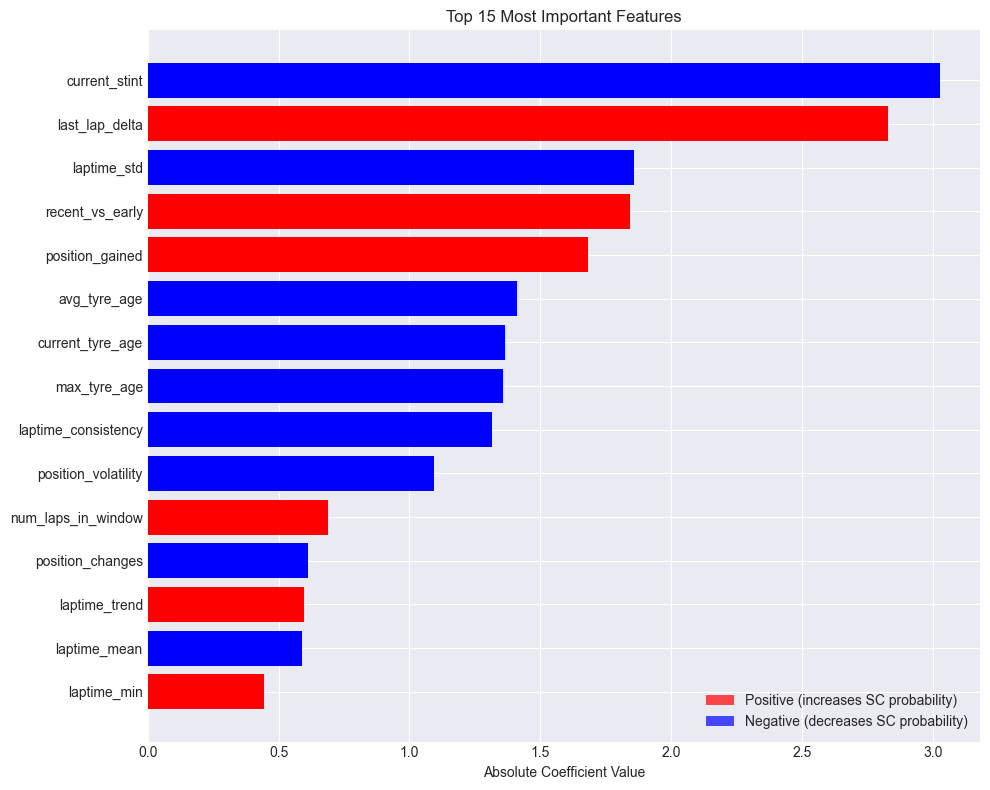

🔍 Top 5 features increasing safety car probability:
   last_lap_delta: +2.829
   recent_vs_early: +1.842
   position_gained: +1.683
   num_laps_in_window: +0.690
   laptime_trend: +0.598

🔍 Top 5 features decreasing safety car probability:
   current_stint: -3.029
   laptime_std: -1.860
   avg_tyre_age: -1.413
   current_tyre_age: -1.367
   max_tyre_age: -1.359


In [52]:
# Extract feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(model.coef_[0]),
    'coefficient': model.coef_[0]
}).sort_values('importance', ascending=False)

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)

colors = ['red' if x > 0 else 'blue' for x in top_features['coefficient']]
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()

# Add legend
red_patch = plt.Rectangle((0,0),1,1,fc="red", alpha=0.7)
blue_patch = plt.Rectangle((0,0),1,1,fc="blue", alpha=0.7)
plt.legend([red_patch, blue_patch], 
           ['Positive (increases SC probability)', 'Negative (decreases SC probability)'],
           loc='lower right')

plt.tight_layout()
plt.show()

print("🔍 Top 5 features increasing safety car probability:")
for _, row in feature_importance[feature_importance['coefficient'] > 0].head(5).iterrows():
    print(f"   {row['feature']}: +{row['coefficient']:.3f}")

print("\n🔍 Top 5 features decreasing safety car probability:")
for _, row in feature_importance[feature_importance['coefficient'] < 0].head(5).iterrows():
    print(f"   {row['feature']}: {row['coefficient']:.3f}")

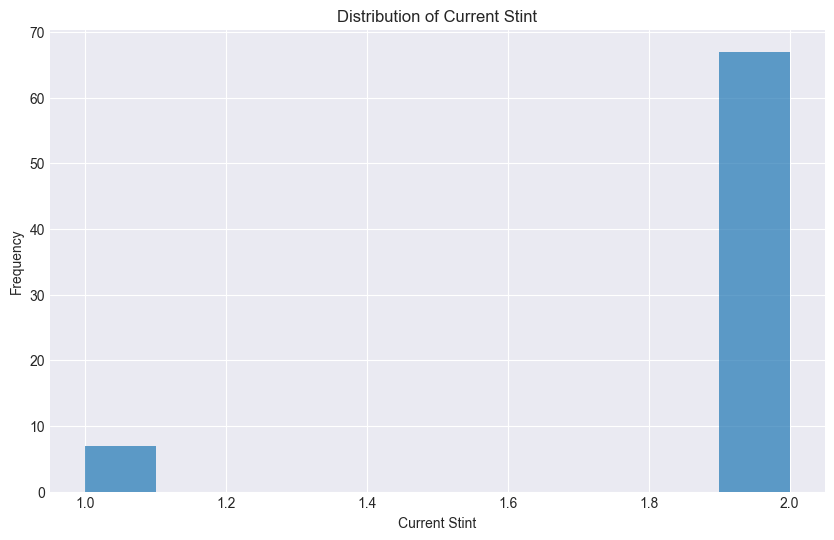

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(driver_features_df['current_stint'], bins=10, alpha=0.7)
plt.xlabel('Current Stint')
plt.ylabel('Frequency')
plt.title('Distribution of Current Stint')
plt.show()

## 📊 Chapter 6: Model Evaluation

### 6.1 Making Predictions

In [ ]:
# Make predictions
y_pred = model.predict(X_scaled)
y_pred_proba = model.predict_proba(X_scaled)[:, 1]

# Add predictions back to our dataframe
full_df['predicted_sc'] = y_pred
full_df['sc_probability'] = y_pred_proba

print(f"Predictions made: {len(y_pred)}")
print(f"Predicted safety cars: {sum(y_pred)}")
print(f"Actual safety cars: {sum(y)}")

Predictions made: 1351
Predicted safety cars: 122
Actual safety cars: 36


### 6.2 Confusion Matrix Analysis

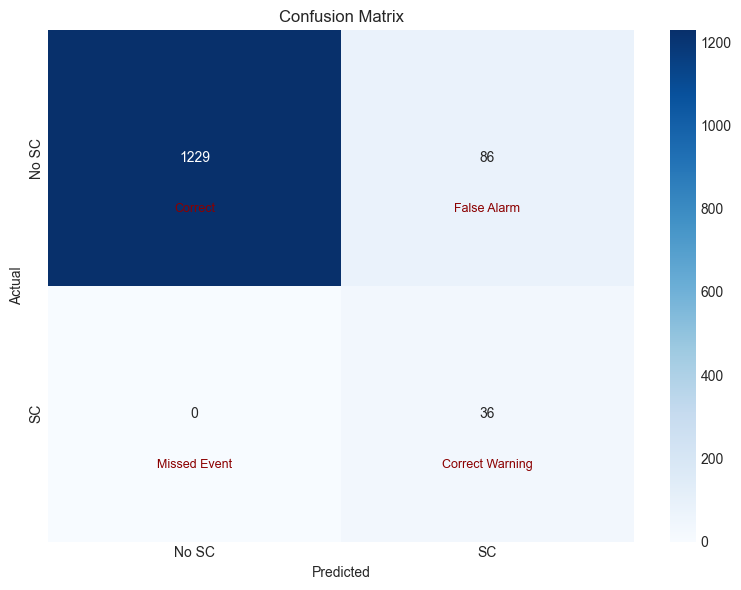

📈 Model Performance:
   Accuracy: 93.6%
   Precision: 29.5% (When we predict SC, how often are we right?)
   Recall: 100.0% (What % of actual SCs did we predict?)
   F1 Score: 0.456


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No SC', 'SC'], 
            yticklabels=['No SC', 'SC'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Add detailed annotations
for i in range(2):
    for j in range(2):
        if i == j:
            label = "Correct" if i == 0 else "Correct Warning"
        else:
            label = "Missed Event" if i == 1 else "False Alarm"
        plt.text(j + 0.5, i + 0.7, label, 
                ha='center', va='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"📈 Model Performance:")
print(f"   Accuracy: {accuracy:.1%}")
print(f"   Precision: {precision:.1%} (When we predict SC, how often are we right?)")
print(f"   Recall: {recall:.1%} (What % of actual SCs did we predict?)")
print(f"   F1 Score: {f1:.3f}")

### 6.3 Analyzing Predictions by Driver

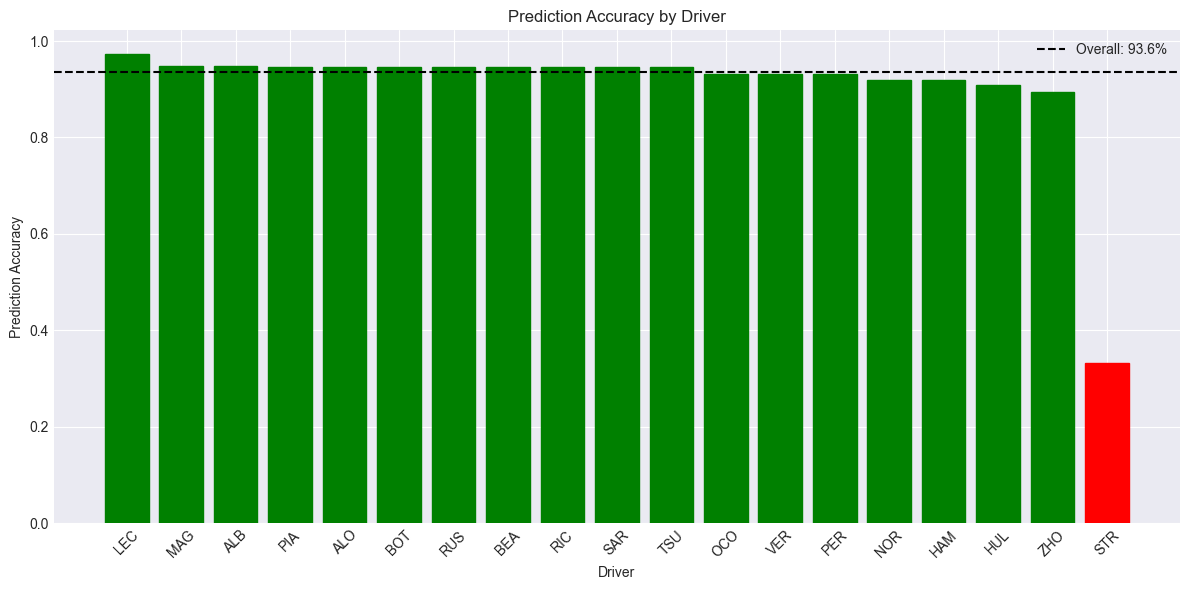

In [ ]:
# Driver-level performance
driver_performance = []

for driver in full_df['driver'].unique():
    driver_data = full_df[full_df['driver'] == driver]
    
    if len(driver_data) > 0:
        driver_accuracy = (driver_data['predicted_sc'] == driver_data['target_sc']).mean()
        driver_performance.append({
            'driver': driver,
            'accuracy': driver_accuracy,
            'predictions': len(driver_data),
            'sc_events': driver_data['target_sc'].sum()
        })

driver_perf_df = pd.DataFrame(driver_performance).sort_values('accuracy', ascending=False)

# Visualize
plt.figure(figsize=(12, 6))
bars = plt.bar(driver_perf_df['driver'], driver_perf_df['accuracy'])

# Color code by performance
for i, (bar, acc) in enumerate(zip(bars, driver_perf_df['accuracy'])):
    if acc >= 0.8:
        bar.set_color('green')
    elif acc >= 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.axhline(y=accuracy, color='black', linestyle='--', label=f'Overall: {accuracy:.1%}')
plt.xlabel('Driver')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy by Driver')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 🎯 Chapter 7: Temporal Analysis of Predictions

### 7.1 Prediction Lead Times

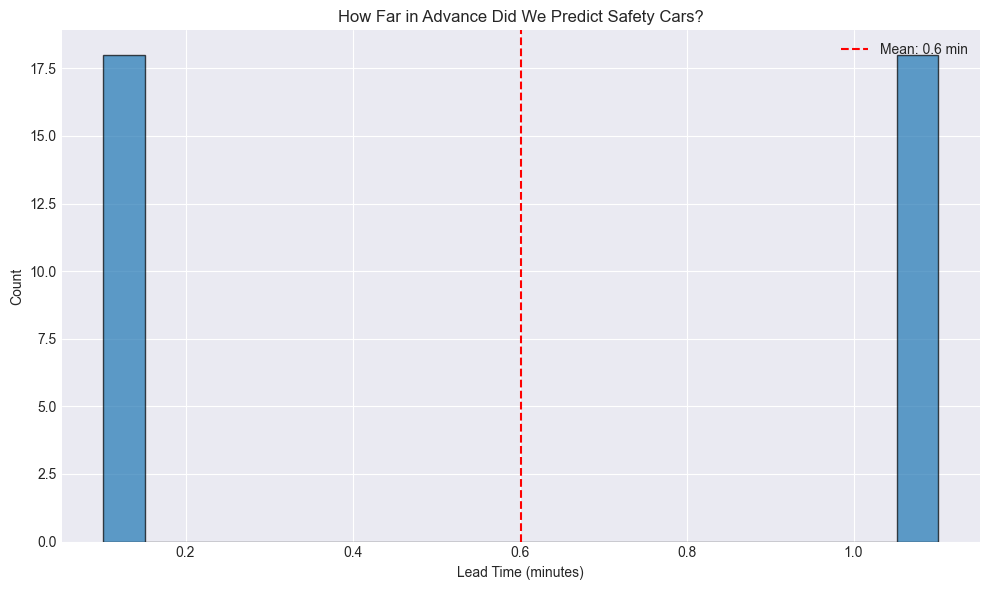

In [ ]:
# Find successful predictions
successful_predictions = full_df[
    (full_df['predicted_sc'] == 1) & 
    (full_df['target_sc'] == 1)
].copy()

# For each successful prediction, calculate how far in advance we predicted
if len(successful_predictions) > 0 and len(sc_times) > 0:
    lead_times = []
    
    for _, pred in successful_predictions.iterrows():
        pred_time = pred['prediction_time']
        
        # Find the closest SC after this prediction
        future_scs = [sc for sc in sc_times if sc > pred_time]
        if future_scs:
            closest_sc = min(future_scs)
            lead_time = (closest_sc - pred_time).total_seconds() / 60
            if lead_time <= 2:  # Within our prediction window
                lead_times.append(lead_time)
    
    if lead_times:
        plt.figure(figsize=(10, 6))
        plt.hist(lead_times, bins=20, edgecolor='black', alpha=0.7)
        plt.axvline(np.mean(lead_times), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(lead_times):.1f} min')
        plt.xlabel('Lead Time (minutes)')
        plt.ylabel('Count')
        plt.title('How Far in Advance Did We Predict Safety Cars?')
        plt.legend()
        plt.tight_layout()
        plt.show()

### 7.2 Probability Calibration

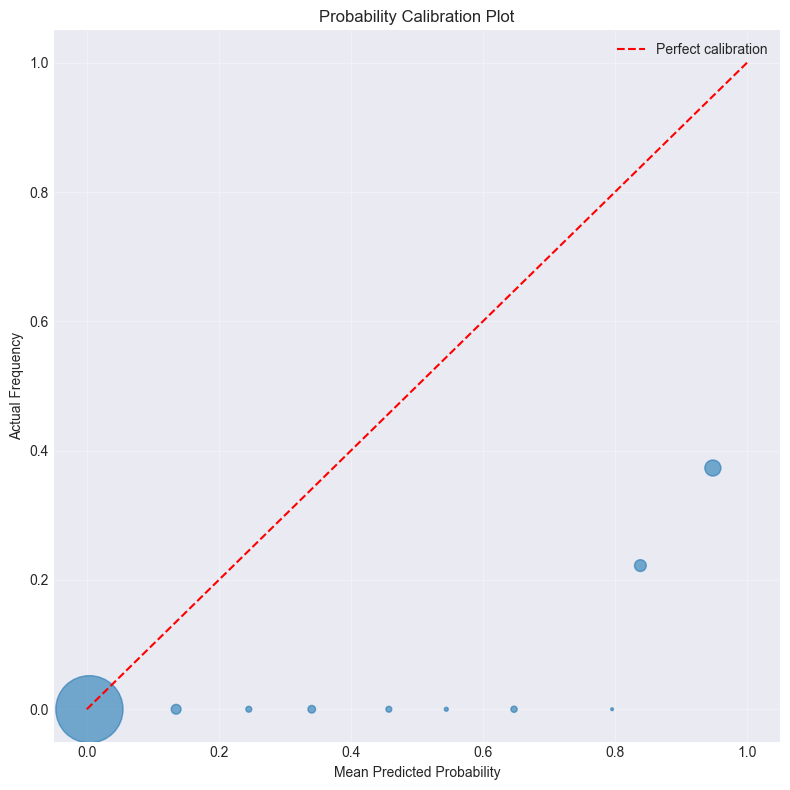

In [ ]:
# Analyze probability calibration
prob_bins = np.linspace(0, 1, 11)
calibration_data = []

for i in range(len(prob_bins) - 1):
    bin_mask = (full_df['sc_probability'] >= prob_bins[i]) & \
               (full_df['sc_probability'] < prob_bins[i+1])
    
    if bin_mask.sum() > 0:
        actual_rate = full_df.loc[bin_mask, 'target_sc'].mean()
        predicted_rate = full_df.loc[bin_mask, 'sc_probability'].mean()
        
        calibration_data.append({
            'bin_center': (prob_bins[i] + prob_bins[i+1]) / 2,
            'predicted_probability': predicted_rate,
            'actual_frequency': actual_rate,
            'count': bin_mask.sum()
        })

calib_df = pd.DataFrame(calibration_data)

# Plot calibration
plt.figure(figsize=(8, 8))
plt.scatter(calib_df['predicted_probability'], 
           calib_df['actual_frequency'], 
           s=calib_df['count']*2, alpha=0.6)

# Perfect calibration line
plt.plot([0, 1], [0, 1], 'r--', label='Perfect calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Frequency')
plt.title('Probability Calibration Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 🎓 Chapter 8: Key Insights and Takeaways

### 8.1 What Makes This Approach "Temporal"?

In [ ]:
print("🕐 TEMPORAL ASPECTS OF OUR APPROACH:\n")

print("1. SLIDING WINDOWS:")
print("   - We move through the race minute-by-minute")
print("   - Each prediction uses only past data (no future leakage)")
print("   - Mimics real-time prediction scenario\n")

print("2. TIME-BASED FEATURES:")
print("   - Trends over time (lap time deterioration)")
print("   - Recent changes (last lap delta)")
print("   - Time-dependent factors (tire age)\n")

print("3. TEMPORAL VALIDATION:")
print("   - We know WHEN each prediction was made")
print("   - Can measure lead times for warnings")
print("   - Proper temporal ordering prevents data leakage")

🕐 TEMPORAL ASPECTS OF OUR APPROACH:

1. SLIDING WINDOWS:
   - We move through the race minute-by-minute
   - Each prediction uses only past data (no future leakage)
   - Mimics real-time prediction scenario

2. TIME-BASED FEATURES:
   - Trends over time (lap time deterioration)
   - Recent changes (last lap delta)
   - Time-dependent factors (tire age)

3. TEMPORAL VALIDATION:
   - We know WHEN each prediction was made
   - Can measure lead times for warnings
   - Proper temporal ordering prevents data leakage


### 8.2 Feature Engineering Insights

In [ ]:
# Summarize feature categories and their importance
feature_categories = {
    'Lap Performance': ['laptime_mean', 'laptime_std', 'laptime_consistency'],
    'Trends': ['laptime_trend', 'recent_vs_early', 'last_lap_delta'],
    'Position': ['current_position', 'position_changes', 'position_volatility'],
    'Strategy': ['current_tyre_age', 'current_stint', 'stint_changes']
}

print("📊 FEATURE ENGINEERING INSIGHTS:\n")

for category, features in feature_categories.items():
    cat_features = feature_importance[feature_importance['feature'].isin(features)]
    if len(cat_features) > 0:
        avg_importance = cat_features['importance'].mean()
        print(f"{category}:")
        print(f"   Average importance: {avg_importance:.3f}")
        
        # Most important in category
        top_feature = cat_features.iloc[0]
        print(f"   Most important: {top_feature['feature']} ({top_feature['importance']:.3f})")
        print(f"   Direction: {'Increases' if top_feature['coefficient'] > 0 else 'Decreases'} SC probability\n")

📊 FEATURE ENGINEERING INSIGHTS:

Lap Performance:
   Average importance: 1.255
   Most important: laptime_std (1.860)
   Direction: Decreases SC probability

Trends:
   Average importance: 1.757
   Most important: last_lap_delta (2.829)
   Direction: Increases SC probability

Position:
   Average importance: 0.640
   Most important: position_volatility (1.093)
   Direction: Decreases SC probability

Strategy:
   Average importance: 1.492
   Most important: current_stint (3.029)
   Direction: Decreases SC probability



### 8.3 Model Performance Summary

In [ ]:
# Create a comprehensive performance summary
print("🏁 MODEL PERFORMANCE SUMMARY:\n")

print(f"Overall Metrics:")
print(f"   Accuracy: {accuracy:.1%}")
print(f"   Precision: {precision:.1%}")
print(f"   Recall: {recall:.1%}")
print(f"   F1 Score: {f1:.3f}\n")

print(f"Prediction Statistics:")
print(f"   Total predictions: {len(full_df)}")
print(f"   Positive predictions: {sum(y_pred)} ({sum(y_pred)/len(y_pred)*100:.1f}%)")
print(f"   Actual positives: {sum(y)} ({sum(y)/len(y)*100:.1f}%)\n")

print(f"Error Analysis:")
print(f"   False alarms: {fp} ({fp/len(y)*100:.1f}% of all predictions)")
print(f"   Missed events: {fn} ({fn/sum(y)*100:.1f}% of actual events)")

🏁 MODEL PERFORMANCE SUMMARY:

Overall Metrics:
   Accuracy: 93.6%
   Precision: 29.5%
   Recall: 100.0%
   F1 Score: 0.456

Prediction Statistics:
   Total predictions: 1351
   Positive predictions: 122 (9.0%)
   Actual positives: 36 (2.7%)

Error Analysis:
   False alarms: 86 (6.4% of all predictions)
   Missed events: 0 (0.0% of actual events)


## 💡 Chapter 9: Practical Applications and Improvements

### 9.1 Real-World Applications

In [ ]:
print("🏆 POTENTIAL APPLICATIONS:\n")

applications = [
    ("Team Strategy", "Predict optimal pit stop timing to avoid SC disruption"),
    ("Broadcasting", "Alert TV directors to potential incidents before they occur"),
    ("Fan Engagement", "Real-time probability displays for betting/fantasy sports"),
    ("Safety Systems", "Pre-position marshals and equipment based on risk levels"),
    ("Driver Coaching", "Identify high-risk situations for defensive driving")
]

for title, desc in applications:
    print(f"• {title}:")
    print(f"  {desc}\n")

🏆 POTENTIAL APPLICATIONS:

• Team Strategy:
  Predict optimal pit stop timing to avoid SC disruption

• Broadcasting:
  Alert TV directors to potential incidents before they occur

• Fan Engagement:
  Real-time probability displays for betting/fantasy sports

• Safety Systems:
  Pre-position marshals and equipment based on risk levels

• Driver Coaching:
  Identify high-risk situations for defensive driving



### 9.2 Visualizing a Race Timeline with Predictions

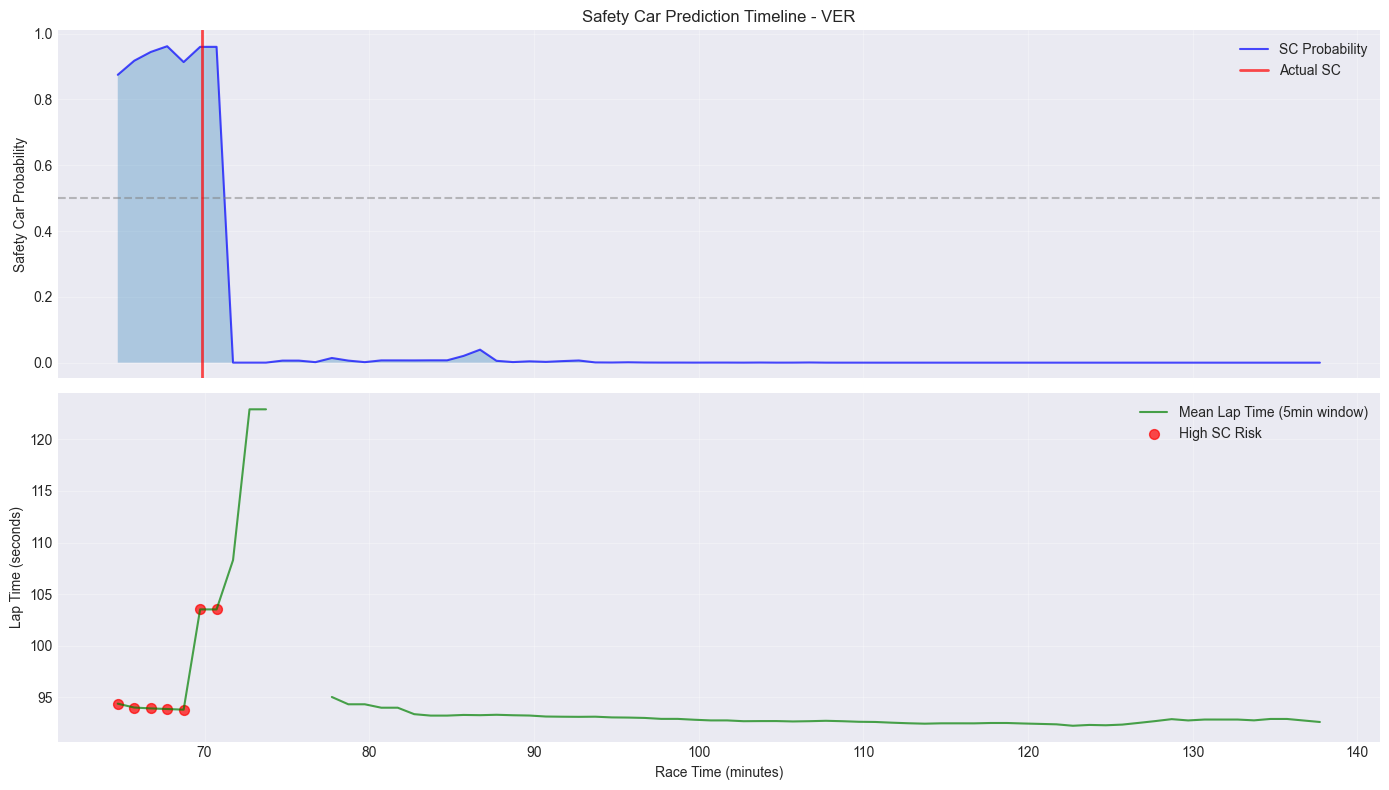

In [ ]:
# Create a timeline visualization showing predictions vs actual events
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Get timeline data for one driver
timeline_driver = 'VER'
driver_timeline = full_df[full_df['driver'] == timeline_driver].sort_values('prediction_time')

# Convert times to minutes for plotting
# prediction_time is already a Timedelta (session time), so just convert to minutes
times_minutes = [t.total_seconds() / 60 for t in driver_timeline['prediction_time']]

# Plot 1: Probability over time
ax1.plot(times_minutes, driver_timeline['sc_probability'], 
         'b-', alpha=0.7, label='SC Probability')
ax1.fill_between(times_minutes, driver_timeline['sc_probability'], 
                 alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Mark actual SC events
for sc_time in sc_times:
    sc_minutes = sc_time.total_seconds() / 60
    ax1.axvline(x=sc_minutes, color='red', linestyle='-', 
                linewidth=2, alpha=0.7, label='Actual SC' if sc_time == sc_times[0] else '')

ax1.set_ylabel('Safety Car Probability')
ax1.set_title(f'Safety Car Prediction Timeline - {timeline_driver}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Lap times with predictions
if 'laptime_mean' in driver_timeline.columns:
    ax2.plot(times_minutes, driver_timeline['laptime_mean'], 
             'g-', alpha=0.7, label='Mean Lap Time (5min window)')
    
    # Highlight high-probability predictions
    high_prob_mask = driver_timeline['sc_probability'] > 0.7
    if high_prob_mask.any():
        high_prob_times = [times_minutes[i] for i in range(len(times_minutes)) if high_prob_mask.iloc[i]]
        high_prob_laptimes = driver_timeline.loc[high_prob_mask, 'laptime_mean']
        ax2.scatter(high_prob_times, high_prob_laptimes, 
                   color='red', s=50, alpha=0.7, label='High SC Risk')

ax2.set_xlabel('Race Time (minutes)')
ax2.set_ylabel('Lap Time (seconds)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9.3 Suggested Improvements

In [ ]:
print("🚀 SUGGESTED IMPROVEMENTS:\n")

improvements = {
    "More Data": [
        "• Use multiple races for training (currently single session)",
        "• Include weather data (rain increases SC probability)",
        "• Add circuit characteristics (street circuits = more SC)"
    ],
    
    "Advanced Features": [
        "• Sector time analysis (identify specific problem areas)",
        "• Speed trap data (sudden speed drops)",
        "• G-force telemetry (detect impacts)",
        "• Radio transcripts (driver reports issues)"
    ],
    
    "Model Enhancements": [
        "• Try ensemble methods (Random Forest, XGBoost)",
        "• LSTM for sequential pattern learning",
        "• Separate models for different SC causes",
        "• Online learning to adapt during race"
    ],
    
    "Validation Strategy": [
        "• Cross-validation across multiple races",
        "• Leave-one-race-out validation",
        "• Temporal validation (train on early season, test on late)",
        "• Driver-specific model evaluation"
    ]
}

for category, items in improvements.items():
    print(f"📌 {category}:")
    for item in items:
        print(f"  {item}")
    print()

## 🎯 Chapter 10: Hands-On Exercises

Now it's your turn! Here are some exercises to deepen your understanding:

### Exercise 1: Feature Investigation

In [ ]:
# TODO: Create a new feature that captures "lap time volatility" 
# in the last 3 laps. High volatility might indicate problems.

def calculate_recent_volatility(window_laps, n_laps=3):
    """
    Calculate the standard deviation of the last n lap times.
    
    Your task: Implement this function
    Hint: Use the last n laps, convert to seconds, calculate std
    """
    # YOUR CODE HERE
    pass

# Test your function
# volatility = calculate_recent_volatility(test_window['laps_data'])
# print(f"Recent volatility: {volatility}")

### Exercise 2: Alternative Target Definition

In [ ]:
# TODO: Instead of predicting "SC in next 2 minutes", create a target
# for "SC in next 5 laps". How does this change model performance?

def create_lap_based_target(windows, sc_times, n_laps_ahead=5):
    """
    Create a target based on laps instead of time.
    
    Your task: For each window, check if SC occurs within next n laps
    Hint: You'll need to track lap numbers and match with SC timing
    """
    # YOUR CODE HERE
    pass

### Exercise 3: Driver-Specific Models

In [ ]:
# TODO: Train separate models for each driver
# Question: Do some drivers have more predictable patterns?

def train_driver_specific_models(full_df, feature_cols):
    """
    Train one model per driver.
    
    Your task: 
    1. Group data by driver
    2. Train individual models
    3. Compare performance
    
    Return: Dictionary of {driver: model}
    """
    # YOUR CODE HERE
    pass

## 📚 Final Thoughts

### What We've Learned:

1. **Temporal Data Processing**: How to create sliding windows that respect time ordering
2. **Feature Engineering**: Extracting meaningful patterns from telemetry data
3. **Imbalanced Classification**: Handling rare events with appropriate techniques
4. **Model Evaluation**: Beyond accuracy - understanding precision, recall, and lead times
5. **Domain Knowledge**: How F1-specific factors influence our approach

### Key Takeaways:

- 🕐 **Time matters**: Proper temporal handling prevents data leakage
- 📊 **Features are crucial**: Domain knowledge helps create meaningful features
- ⚖️ **Balance is hard**: Rare events require special handling
- 🎯 **Metrics matter**: Accuracy alone doesn't tell the whole story
- 🔄 **Iterate**: Start simple, add complexity gradually

### Next Steps:

1. Try this approach on different races
2. Experiment with different window sizes
3. Add weather and track data
4. Explore more sophisticated models
5. Build a real-time prediction system

## 🏁 Conclusion

Congratulations! You've built a temporal machine learning system for predicting Formula 1 safety cars. This approach combines:

- Real-time data processing
- Domain-specific feature engineering  
- Temporal machine learning concepts
- Practical evaluation metrics

The same principles can be applied to many other temporal prediction problems:
- Equipment failure prediction
- Traffic incident detection
- Market event forecasting
- Medical emergency prediction

Remember: In temporal ML, respecting time ordering is crucial. Always ask yourself: "What information would actually be available at prediction time?"

Happy predicting! 🏎️💨

---

### Appendix: Complete Feature Reference

In [ ]:
# Display all features with descriptions
feature_descriptions = {
    'num_laps_in_window': 'Number of completed laps in lookback window',
    'laptime_mean': 'Average lap time in window (seconds)',
    'laptime_std': 'Standard deviation of lap times',
    'laptime_min': 'Fastest lap in window',
    'laptime_max': 'Slowest lap in window',
    'laptime_consistency': 'Coefficient of variation (std/mean)',
    'laptime_trend': 'Linear trend correlation (-1 to 1)',
    'recent_vs_early': 'Recent performance vs early window (seconds)',
    'last_lap_delta': 'Change from previous lap (seconds)',
    'current_position': 'Current race position',
    'avg_position': 'Average position in window',
    'position_changes': 'Total position changes',
    'position_gained': 'Net positions gained in window',
    'position_volatility': 'Standard deviation of positions',
    'current_tyre_age': 'Current tire age (laps)',
    'avg_tyre_age': 'Average tire age in window',
    'max_tyre_age': 'Maximum tire age reached',
    'current_stint': 'Current stint number',
    'stint_changes': 'Number of pit stops in window'
}

print("📖 FEATURE REFERENCE GUIDE:\n")
for feature, description in feature_descriptions.items():
    if feature in feature_cols:
        importance_row = feature_importance[feature_importance['feature'] == feature]
        if not importance_row.empty:
            imp_val = importance_row.iloc[0]['importance']
            print(f"• {feature}:")
            print(f"  Description: {description}")
            print(f"  Importance: {imp_val:.3f}\n")